## 1. Download Tile Images from JAXA Monitor Website 

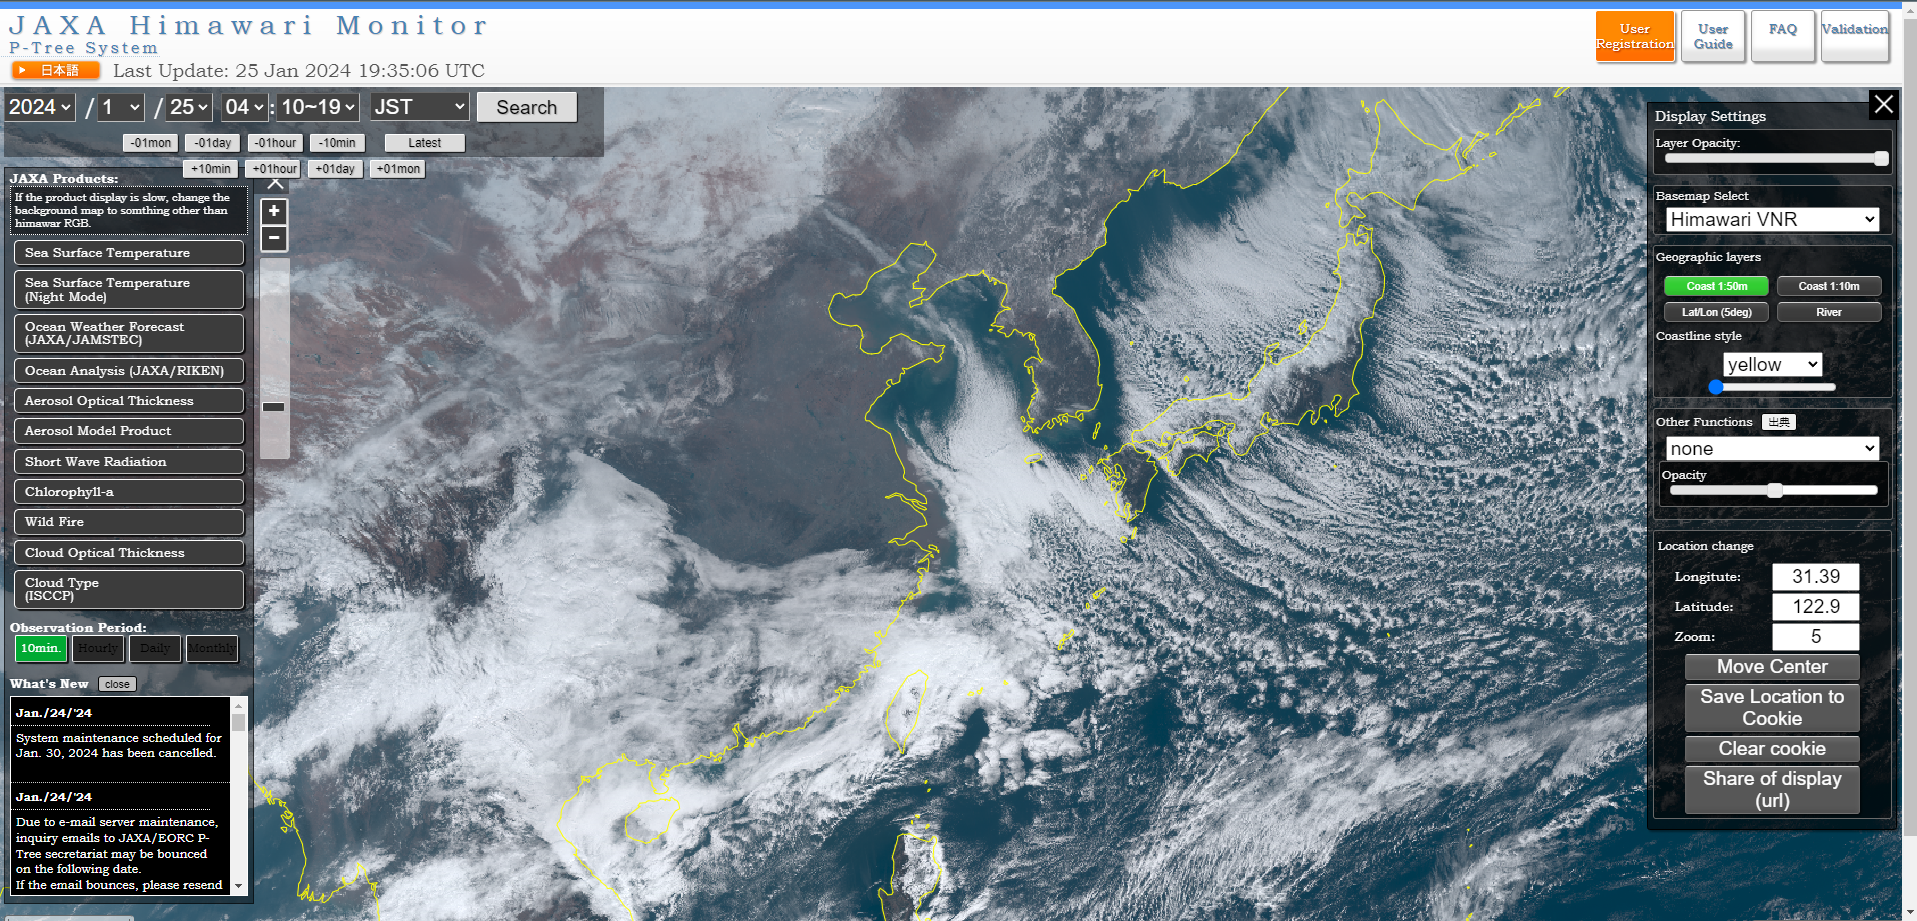

### Download Tile Images

In [10]:
import requests # request img from web
import shutil # save img locally
from datetime import datetime, date, time, timezone,  timedelta
import hashlib
import time
from pyproj import CRS
from pyproj import Transformer
import cv2
import os

In [2]:
def download_tiles(dt):
    urlTemp = 'https://www.eorc.jaxa.jp/cgi-bin/ptree/tilemap/H09/tilemap_rgb_v1r2.py?z=5&x=*XX&y=*YY&prd=VIS&date='+dt+'&term=T10m&ver=000'

    cc=0
    for xx in range(25,28):     #26,27
        for yy in range(18,21): #11,12
            url = urlTemp.replace('*XX', str(xx))
            url = url.replace('*YY', str(yy))

            res = requests.get(url, stream=True)
            if res.status_code == 200:
                file_name = f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_{cc}.png'
                with open(file_name, 'wb') as f:
                    shutil.copyfileobj(res.raw, f)
                    #print('Image sucessfully Downloaded: ', file_name)
            else:
                print(r"Image Couldn't be retrieved")
            cc = cc + 1

            time.sleep(2)

    print(dt, ' - images are downloaded')

In [3]:
def merge_tiles_to_big_image(dt):
    ## Merge Images
    img1 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_0.png')
    img2 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_1.png')
    img3 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_2.png')
    img4 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_3.png')
    img5 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_4.png')
    img6 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_5.png')
    img7 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_6.png')
    img8 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_7.png')
    img9 = cv2.imread(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_8.png')
    im_col1 = cv2.vconcat([img3, img2, img1])
    im_col2 = cv2.vconcat([img6, img5, img4])
    im_col3 = cv2.vconcat([img9, img8, img7])
    im_all = cv2.hconcat([im_col1,im_col2,im_col3])

    cv2.imwrite(f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\big\\h9_satellite_vis_05_{dt}_all_9tiles.png', im_all)
    print(dt, ' - tiles are merged')

In [4]:
def remove_files(dt):
    for k in range (9):
        url = f'D:\\Tommy\\+WeatherData\\Himawari\\sat_images\\h9_satellite_vis_05_{dt}_{k}.png'
        os.remove(url)

### Download and merge into one full image

In [5]:
dt = '202403180000'
download_tiles(dt)
merge_tiles_to_big_image(dt)
remove_files(dt)

202403180000  - images are downloaded
202403180000  - tiles are merged


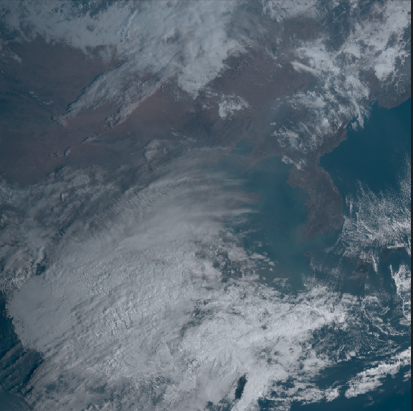

### Download and merge images for 24 hours

In [ ]:
for h in range (0,24):
    hh = f'{h:02d}'
    for m in range(0,60,10):
        mm = f'{m:02d}'
    mm='00'
    dt='20240318'+(hh+mm)
    print(dt)
    download_tiles(dt)
    merge_tiles_to_big_image(dt)
    remove_files(dt)
    time.sleep(30)

### Convert Boundary from wgs84 to Mercator

In [11]:
#WGS84 convert to web Mercator
from_crs_2 = CRS.from_epsg(4326)
to_crs_2 = CRS.from_epsg(3857)
transformer_2 = Transformer.from_crs(from_crs_2, to_crs_2, always_xy=True)

In [12]:
lonmin = 71
lonmax = 136
latmin = 15
latmax = 55

#top left
x1,y1 = transformer_2.transform(lonmin, latmax)
#bottom right
x2,y2 = transformer_2.transform(lonmax, latmin)

xmin = x1
xmax = x2
ymin = y2
ymax = y1

print(xmin,xmax,ymin,ymax)

7903683.846322423 15139450.747885207 1689200.1396078935 7361866.113051188


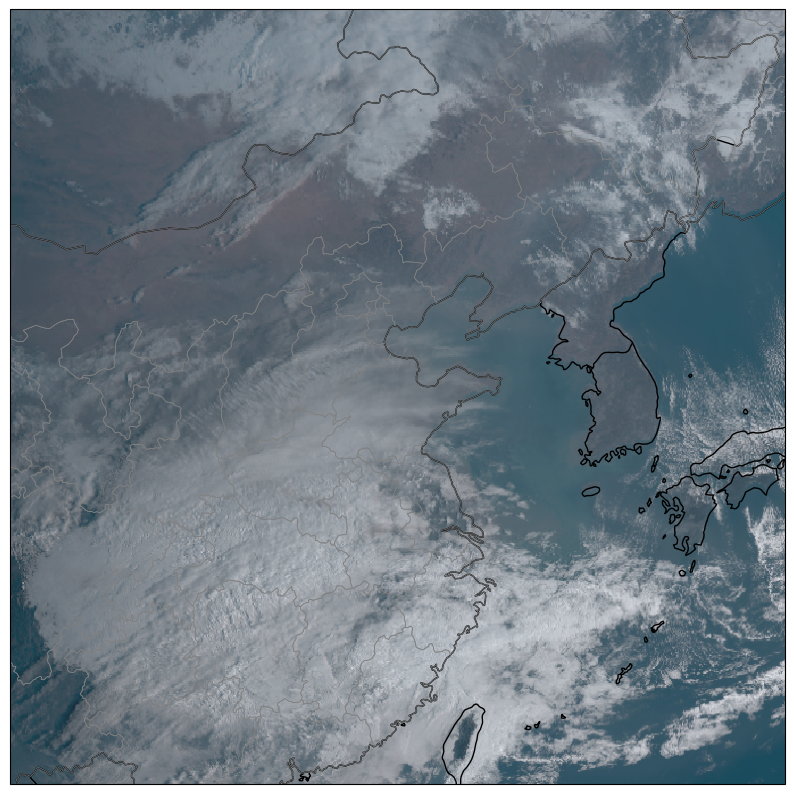

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the Google tile radar image
#radar_tile = plt.imread(r'D:\Tommy\+WeatherData\accu_aqi_tiles\plumb\test\20230503-10-55-38.png')
satellite_tile = plt.imread(r'D:\Tommy\+WeatherData\Himawari\sat_images\big\h9_satellite_vis_05_202403180000_all_9tiles.png')

# Define the map projection
proj = ccrs.Mercator()
#proj = ccrs.PlateCarree()
# Plot the radar tile image
fig = plt.figure(figsize=(10, 10.5))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the country borders

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
#cfeature.BORDERS
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
ax.add_feature(cfeature.COASTLINE,linestyle='-', edgecolor='black', linewidth=1)
ax.add_feature(cfeature.STATES,linestyle='-', edgecolor='gray', linewidth=0.5)


# Plot the radar tile image on the map 
#extent is [xmin,xmax,ymin,ymax]
ax.imshow(satellite_tile, origin='upper', extent=[11271098, 15028131, 2504689, 6261721],transform=proj, alpha=0.9)

# Set the x and y axis limits
#ax.set_xlim(xmin,xmax) #[xmin,xmax]
#ax.set_ylim( ymin,ymax) #[ymin, ymax]

# Save the final image
#plt.savefig(r'D:\Tommy\+WeatherData\china_aqi_map\aqiimage_with_borders.png', dpi=300, bbox_inches='tight')